<a href="https://colab.research.google.com/github/shiwoei-ai/ai_tech_and_biz_app_course/blob/main/workshop3A_r1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 程式執行環境的準備
# 載入必要套件

# 載入標準數據分析、畫圖套件
# 載入可以協助清楚呈現與評估分類模型表現的套件
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 載入建立類神經網路模型所需套件
# 因為要建立 CNN 模型，所以把用於建立卷積層
# 及池化層的基本元件讀進來。
# Conv2D, MaxPooling2D 當然是 CNN 必備的，
# 而 Flatten 則可以把最後一個個記分板（特徵圖）
# 攤平並合併成為一個向量。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 讓圖直接在 notebook 中顯示
%matplotlib inline

In [2]:
# 2. 資料載入及檢查（Loading Data）
# 由於我們已經在使用全連結神經網路建模時檢查過這筆資料，
# 所以我們在這個程式中就不再多做額外的檢查。
# 不熟悉這筆資料的同學可參考 Workshop 2A 的程式碼。

# 載入 MNIST 手寫數字資料集
# MNIST 資料集包含 60,000 張訓練圖像與 10,000 張測試圖像，
# 每張圖為 28x28 灰階圖
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# 3. 資料前處理
# 將影像資料 reshape 成 CNN 可接受的格式
# （samples, height, width, channels）
# 其中 samples 是指有多少筆資料（多少張圖片），
# height 與 width 則是圖片的高與寬，
# 而最後的 channels 是指輸入圖片的通道數。
# 如果是用 RGB 三種顏色的彩色圖片，
# 則通道數 channels = 3。
# 但因為 MNIST 資料集只是灰階圖，
# 所以只會有一個用來表示深淺的通道，
# 所以 channels = 1。
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32')
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32')

# 將像素值正規化（把 0-255 轉換成 0-1 之間的數據）
# 這樣做可以加速模型收斂與提高穩定性
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encoding 標籤
# 為分類輸出所做的資料前處理
# （因 MNIST 有 10 個類別，分別為數字 0~9）
n_classes = 10
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [4]:
# 4. 建立模型（Convolutional Neural Network，CNN）
# 我們在此宣告 CNN 模型的結構
# 在此考量的幾個簡單設計原則
#
# (1) 小卷積核 (3×3)
# 3×3 已足以捕捉局部特徵，參數數量也比 5×5 少。
#
# (2) 逐層加深 + 池化降維
# 用少數卷積層（2–3 層）搭配 MaxPooling，
# 讓模型能抓到由低階到高階的特徵。
#
# (3) 使用 Dropout 防止過擬合
# 雖然 MNIST 不大，但簡單的 Dropout 仍能讓模型泛化更好。
#
# (4) 參數量適中
# 控制參數量讓計算負擔不至太大，但效能足以突破 Dense NN。


# 首先，建立一個空的序列模型（Sequential）
model = Sequential()

# Block 1: 卷積 + 池化
# 使用兩層 3x3 卷積，讓模型學習局部邊緣/筆劃特徵
model.add(Conv2D(32,(3,3),padding="same",
                        activation="relu",
                        input_shape=(28, 28, 1)))
model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
# 用 MaxPooling 將 feature map 壓縮成一半大小
model.add(MaxPooling2D((2,2)))
# 用 Dropout 隨機丟棄 25% 的神經元，降低過擬合
model.add(Dropout(0.25))


# Block 2: 更深一層卷積
# 增加 filter 數量到 64，學習更複雜的形狀
model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


# 分類器（全連接層）
# Flatten：把 feature map 攤平成一維向量
model.add(Flatten())
# Dense(128)：小型隱藏層，負責整合特徵
model.add(Dense(128,activation="relu"))
# Dropout(0.5)：在分類頭加強正則化，避免過擬合
model.add(Dropout(0.5))
# 輸出層：10 個類別，使用 softmax
model.add(Dense(n_classes,activation="softmax"))


# 顯示模型摘要
# - 可以看到每層的輸入輸出尺寸、參數數量
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 5. 編譯模型
# 主要設定包括：
# Optimizer: Adam（常見且穩定），
# Loss: categorical_crossentropy（適用於多類別分類），
# Metrics: accuracy（在訓練過程中提供「準確率」資訊）
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 加入Callbacks 設定，包括
# EarlyStopping：若驗證集 loss 連續 3 epoch 沒改善，
#                就停止訓練並回復最佳權重
# ModelCheckpoint：保存驗證準確率最佳的模型
callbacks = [
  EarlyStopping(monitor="val_loss",
                patience=3,
                restore_best_weights=True),
  ModelCheckpoint("mnist_cnn_best.keras",
                  monitor="val_accuracy",
                  save_best_only=True)
]

In [6]:
# 6. 訓練模型
# 以下程式碼的說明：
# - X_train, y_train：訓練資料與標籤
# - batch_size=128：訓練時用 128 筆樣本做為一批次（更新一次權重）
# - epochs=15：完整訓練資料迭代 10 次
# - verbose=1：訓練過程會顯示進度條與損失/準確率
# - validation_data=(X_test, y_test)：在每個 epoch 結束後使用測試集評估模型表現
model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=15,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7933 - loss: 0.6087 - val_accuracy: 0.9833 - val_loss: 0.0539
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9706 - loss: 0.1006 - val_accuracy: 0.9900 - val_loss: 0.0331
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9794 - loss: 0.0699 - val_accuracy: 0.9912 - val_loss: 0.0257
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9848 - loss: 0.0527 - val_accuracy: 0.9921 - val_loss: 0.0219
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9876 - loss: 0.0421 - val_accuracy: 0.9930 - val_loss: 0.0191
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9886 - loss: 0.0383 - val_accuracy: 0.9934 - val_loss: 0.0193
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9890 - loss: 0.0372 - val_accuracy: 0.9942 - val_loss: 0.0186
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9901 - loss: 0.0336 - val_accuracy: 

In [7]:
# 7. 評估模型

# 對測試集進行初步評估（loss 和 accuracy）
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# 對測試集進行並產生混淆矩陣
# 以進行不同數字的預測準確度報告
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)      # 將預測結果轉成類別
y_true_classes = np.argmax(y_test, axis=1)      # 將真實標籤轉成類別

# 混淆矩陣
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

# 分類報告（precision, recall, f1-score）
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9926 - loss: 0.0219
Test Loss: 0.01759611815214157
Test Accuracy: 0.9944999814033508
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:
 [[ 977    0    0    1    0    0    0    0    2    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [   0    1 1030    0    0    0    0    1    0    0]
 [   0    0    0 1006    0    3    0    0    1    0]
 [   0    0    0    0  979    0    0    0    0    3]
 [   0    0    0    7    0  884    1    0    0    0]
 [   4    2    0    1    1    3  945    0    2    0]
 [   0    2    3    1    0    0    0 1020    0    2]
 [   1    0    1    3    0    0    0    0  968    1]
 [   0    0    0    0    5    0    0    0    2 1002]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99     

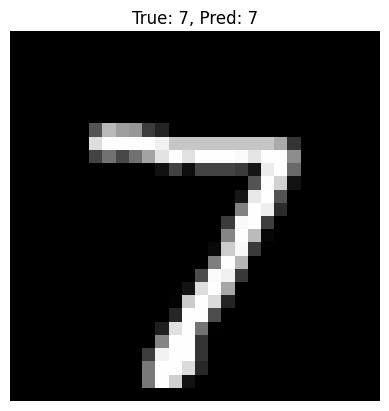

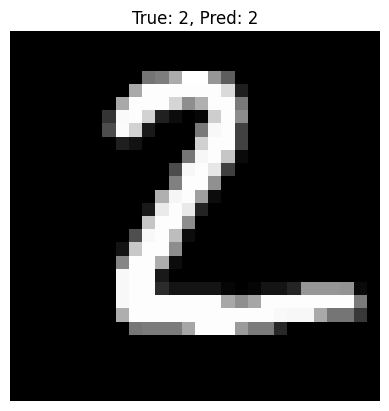

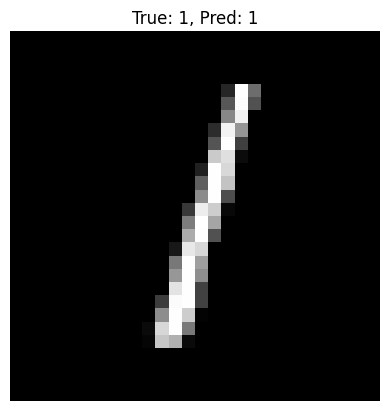

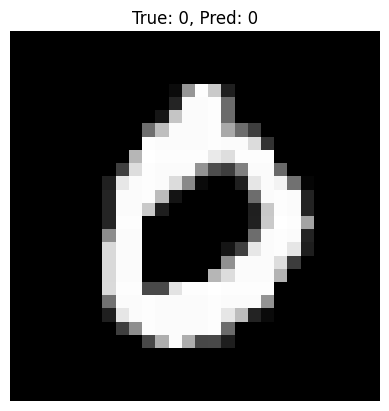

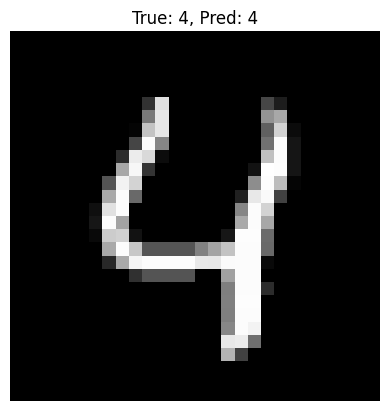

In [8]:
# 8. 輸入照片行實測
# 顯示前 5 張圖片與預測結果
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(X_test[i].reshape(X_test.shape[1], X_test.shape[2]), cmap='gray')
    plt.title(f"True: {y_true_classes[i]}, Pred: {y_pred_classes[i]}")
    plt.axis('off')
    plt.show()